# Imports 

In [1]:
#%matplotlib inline
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pickle
import sklearn.decomposition
import sklearn.cluster
import matplotlib.cm
import importlib
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns 

# Helper functions

In [99]:
def cluster_splitter(labels:np.array,xmin:int,xmax:int, zcored:bool=True):

    clusters = np.unique(labels)
    splitted_spks = np.empty(len(clusters),dtype=object)
    if xmax == None:
        xmax = spks.shape[1]
    for clust in clusters:
        selector= np.where(labels==clust)[0]
        if zcored == False:
            selected_spks = spks[selector,xmin:xmax]
        selected_spks = zscore(spks[selector,xmin:xmax], axis = 1)
        splitted_spks[clust] = selected_spks
    return splitted_spks

def get_superneuron(cluster:np.array):
    return cluster.mean(axis=0)

# Data loading
## Spike extraction

In [2]:
data_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont'
video_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont/cam/'

dbs = {'mouse_name': 'TX60', 'date': '2020_10_20', 'exp': '2', 'cam': ['0', '1']}

In [3]:
dat = np.load(os.path.join(data_root, 'spont_2cam_%s_%s.npz'%
                  (dbs['mouse_name'], dbs['date'])))

spks = dat['spks'].astype(np.float32)

Exploring the `npz` data structure:

In [4]:
dat.files

['spks', 'tcam', 'ypos', 'xpos', 'tneural', 'run']

In [5]:
spks.shape

(42568, 23185)

(neurons) x n_samples

## spike normalization

In [6]:
spks -= spks.mean(axis=1)[:,np.newaxis]
spks /= ((spks**2).mean(axis=1)**0.5)[:,np.newaxis]

# Rastermap fit

In [7]:
sys.path.insert(0, '/home/mano/Documents/Profesional Projects/RasterMap')
from rastermap import mapping

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
RM_model = mapping.Rastermap(smoothness=1, 
                           n_clusters=100, 
                           n_PCs=128, 
                           ts=0.9,
                           time_lag_window=0,
                           grid_upsample=10,
                           n_splits=0).fit(spks, normalize=False) # (we've already normalized)

n_PCs = 128 computed, time 24.41
landmarks computed and embedded, time 37.47
grid upsampled, time 39.72


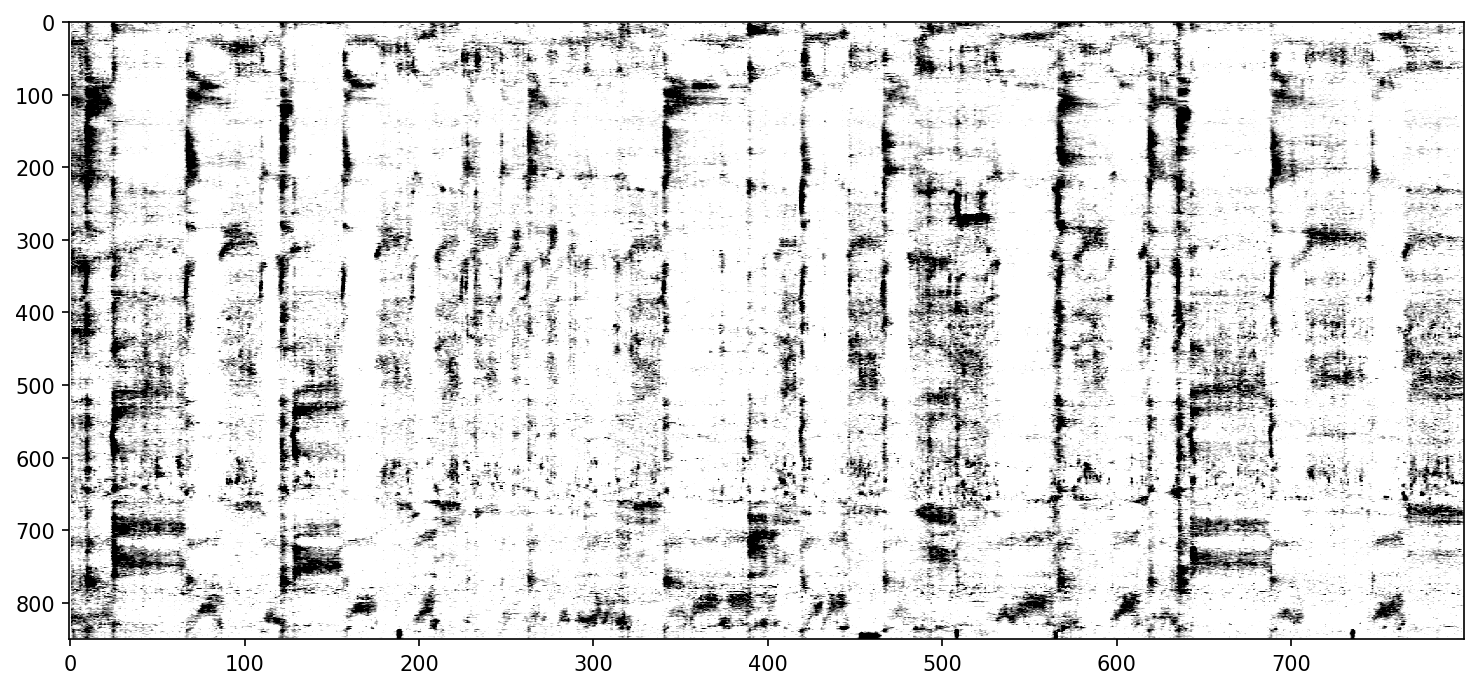

In [98]:
from scipy.stats import zscore
plt.figure(figsize=(12,12), dpi=150)
xmin=0
xmax=xmin+800
plt.subplot(2,1,1)
plt.imshow(zscore(RM_model.X_embedding[:,xmin:xmax], axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

In [93]:
splitted_spks = cluster_splitter(RM_model.embedding_clust, xmin = 0, xmax=800)

In [100]:
splitted_spks[0].shape

(220, 800)

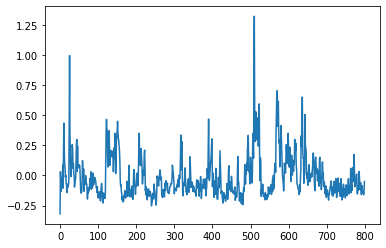

In [101]:
spn0 = get_superneuron(splitted_spks[0])
plt.plot(spn0)

# Rastermap cluster inspection 

In [63]:
def ClusterSelector(labels:np.array, clust:int, xmin:int, xmax:int=None, zcored:bool=True):

    """ 
    Simple cluster selector.

    Parameters
    ----------
    clust : int 
        Number of cluster to be visualized
    xmin : int
        Initial offset 
    xmax : int 
        Final offset
    zcored : bool
        Boolean flag to indicate if the returned value should be zcored 

    Returns
    ----------
    selected_spks: np.array
        Subset of spks in the given window
    superneuron: np.array
        mean over all neurons in the cluster in the given window
    """
    if xmax == None:
        xmax = spks.shape[1]
    selector= np.where(labels==clust)[0]
    selected_spks = spks[selector,xmin:xmax]
    if zcored == True:
        selected_spks = zscore(selected_spks,axis=1)
    superneuron = selected_spks.mean(axis=0)
    return selected_spks, superneuron 

def ClusterVisualizer(selected_spks:np.array):
    import seaborn as sns 
    """
    Simple cluster visualizer

    Parameters
    ----------
    selected_spks: np.array
        Array cointaing the cluster to be visualized
    """

    f, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(10,10), dpi=150)
    ax1.imshow(selected_spks, vmin=0, vmax=2, cmap='gray_r', aspect='auto')
    ax1.set_ylabel('neuron (id)')
    ax2.plot(selected_spks.mean(axis=0), color= 'k')
    ax2.set_title('SuperNeuron activity')
    ax2.set_ylabel('Activity (a.u)')
    ax2.set_xlabel('time $(ms)$')
    sns.despine()

def Get_ACF_PACF(superneuron:np.array, lags:int=30):
    from statsmodels.tsa.stattools import acf, pacf

    """
    Gets the autocorr and partial autocorr of the superneuron 

    Parameters
    ----------
    superneuron: np.array
        Array cointaing superneuron activity
    lags: int
        number of lags to be computed
    Returns:
    ----------

    sn_acf: np.array
        Array containing the autocorrelation of the superneuron activity
    sn_pacf: np.array
        Array containing the partial autocorrelation of the superneuron activity  
    """
    sn_acf = acf(superneuron, nlags=lags, fft=True)
    sn_pacf= pacf(superneuron, nlags=lags)

    return sn_acf,sn_pacf

def ACFViz(acf:np.array, pacf:np.array, alpha=0.025):
    import seaborn as sns 
    from scipy.stats import norm

    """
    Plots the autocorrelation and partial autocorrelation of the signal with CI at a given quantile

    Parameters
    ----------
    acf: np.array
        Array containing the autocorrelation of the superneuron activity
    pacf: np.array
        Array containing the partial autocorrelation of the superneuron activity  
    alpha: Two tailed (!!) confidence value at 95% 
    """

    quantile = norm.ppf(1-alpha)
    ac_se = np.sqrt(1+(2*np.sum(acf**2)))
    acf_ci = quantile * ((ac_se)/np.sqrt(len(superneuron)))
    pacf_ci = quantile / np.sqrt(len(superneuron))
    f, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(10,10), dpi=150)
    
    ax1.stem(acf)
    ax1.axhline(y=acf_ci,linestyle='--',color='gray', label=f"{(1 - alpha)*100} % Confidence interval")
    ax1.axhline(y=-acf_ci,linestyle='--',color='gray')
    ax1.set_ylabel('Autocorrelation')
    ax1.legend()

    ax2.stem(sn_pacf)
    ax2.axhline(y=pacf_ci,linestyle='--',color='gray')
    ax2.axhline(y=-pacf_ci,linestyle='--',color='gray')
    ax2.set_ylabel('Partial Autocorrelation')
    ax2.set_xlabel('Lags')
    sns.despine()

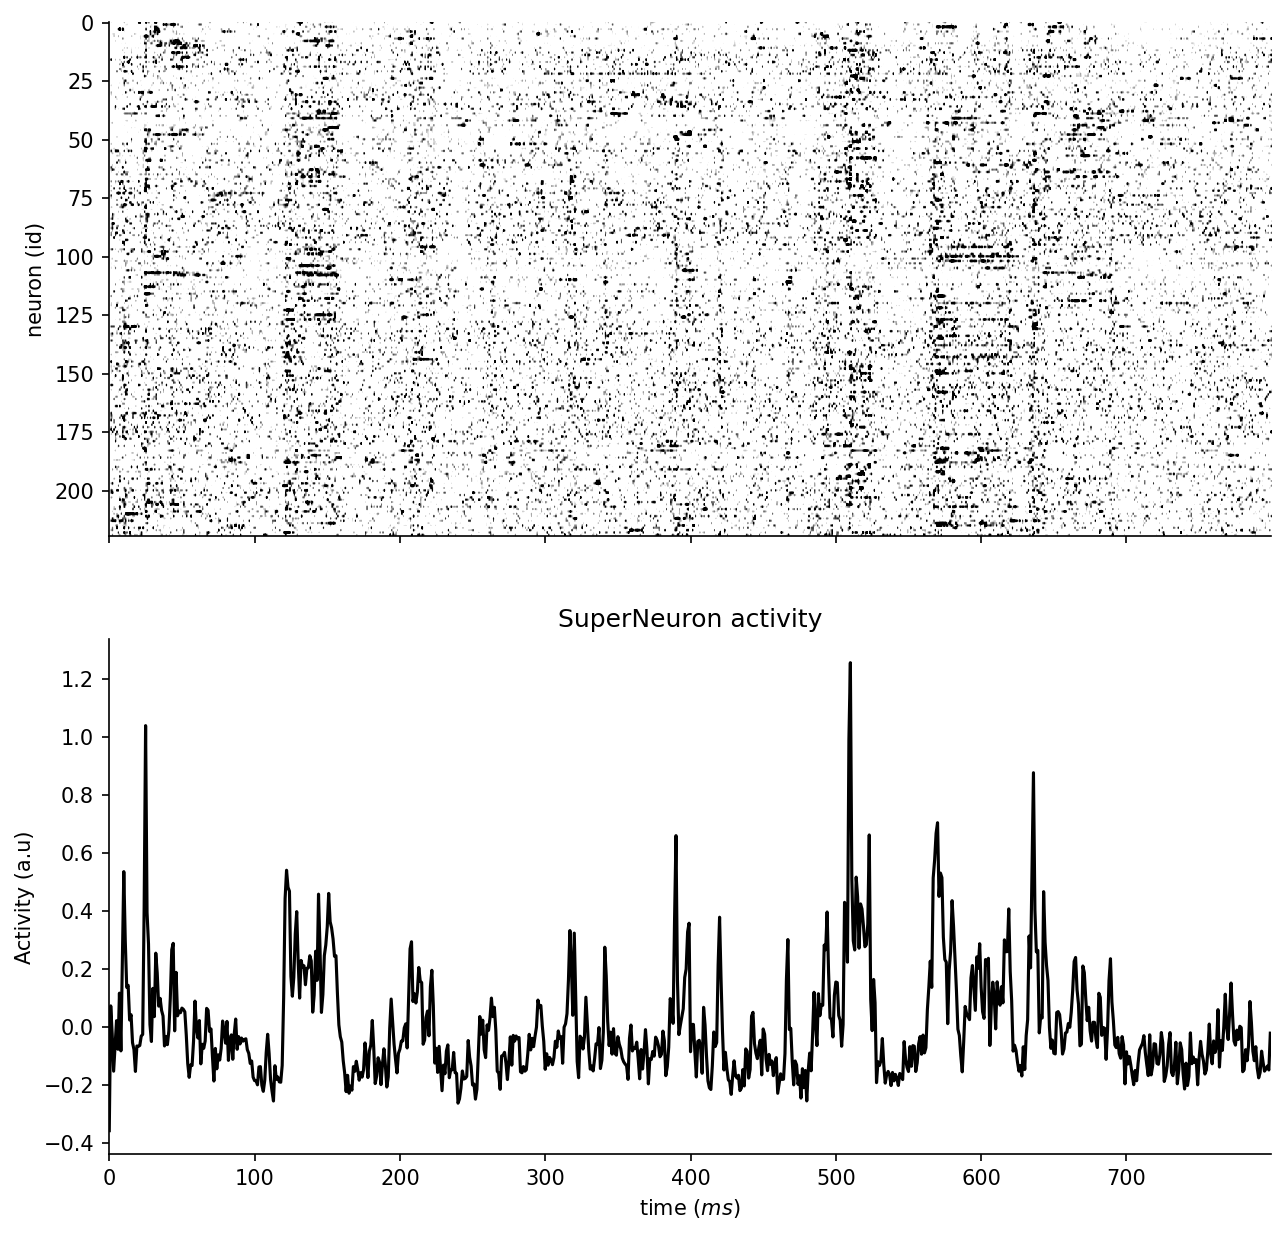

In [15]:
selected_spks, superneuron = ClusterSelector(RM_model.embedding_clust, clust=0, xmin=0, xmax=800, zcored=True)
ClusterVisualizer(selected_spks)

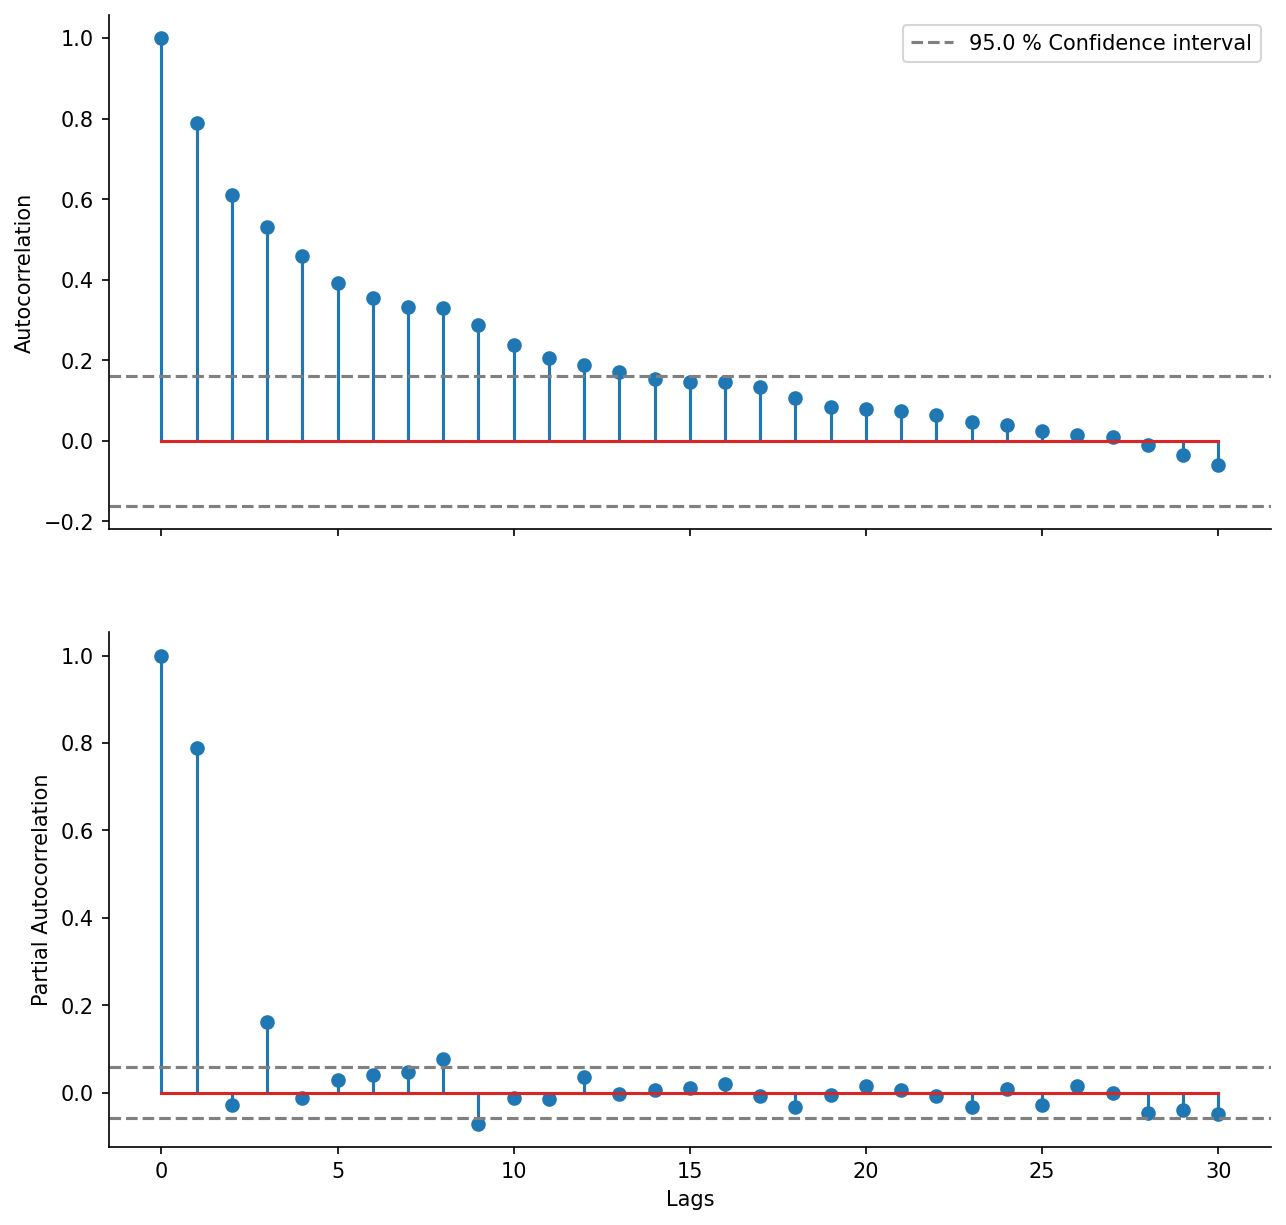

In [60]:
sn_acf, sn_pacf = Get_ACF_PACF(superneuron)
ACFViz(sn_acf,sn_pacf)

## Glosary:

*Autocorrelation* of the superneuron activity:

> probability of finding a spike at time $t+t^{'}$ given a spike at time t, for some range of lags  $t^{'}$

*Crosscorrelation* between superneurons:

> given that superneuron 1 emit a spike at time $t$ what is the probability of seeing a spike from superneuron 2 at time $t+t^{'}$


## Needs work -v 

In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [32]:
n_comps = 128 # chose to match rastermap output dimension 
pca_128 = PCA(n_components=n_comps).fit(spks)

*loadings* = linear combination of the original variables (aka timepoints in this case) from which the principal components (PCs) are constructed. `pca_128.components_`

In [33]:
U = spks@pca_128.components_.T
U.shape

(42568, 128)

### foor loop to try different number of clusters

* Just to test I took 100 clusters

In [176]:
clusters = [50,100,150,200,300,400]
labels = []
centroids = []
sse = []
sil_score = []
for ncluster in clusters:
    kmeans = KMeans(n_clusters=ncluster, n_init=1, random_state=0).fit(U)
    labels.append(kmeans.labels_)
    centroids.append(kmeans.cluster_centers_)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

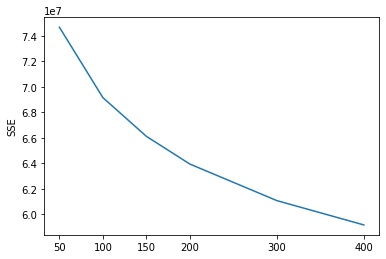

In [177]:
### This makes sense with more models fitted
sse = np.asarray(sse)
fig, ax1 = plt.subplots(1, 1, sharex=True)
clusters_arr = np.asarray(clusters)
ax1.plot(clusters_arr, sse)
ax1.set_xticks(clusters_arr)
ax1.set_ylabel("SSE")
###

# Just neurons sorted by cluster
## Todo: cluster rearrangement 

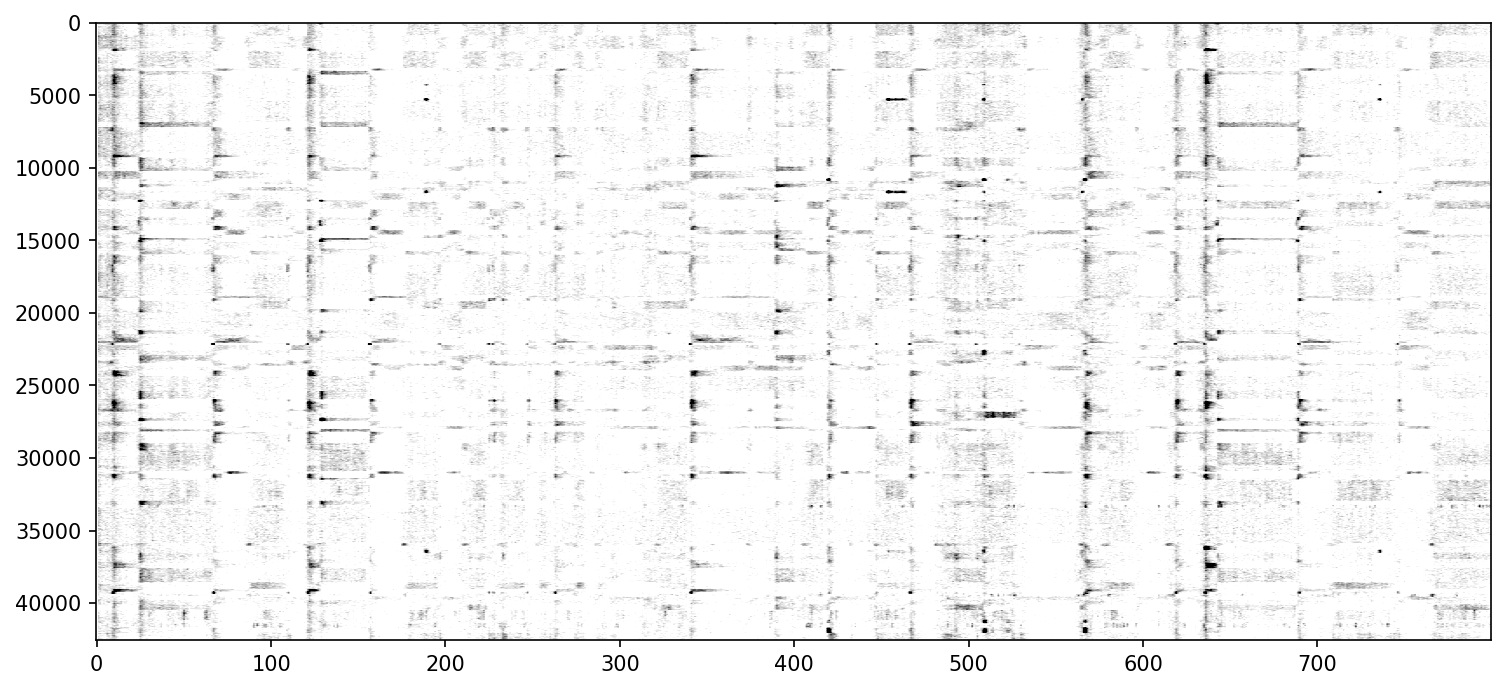

In [178]:
labels = np.asarray(labels[1]) #Getting the labels of the run with 100 clusters
centroids = np.asarray(centroids[1])
sort_idx=np.argsort(labels) 
pc_sort_knn=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_knn, vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Putting similar clusters close each other (?)
I will try to put clusters together by simply doing an agglomerative clustering on the clusters_centers of the Kmeans algo

In [187]:
from sklearn.cluster import AgglomerativeClustering
Cluster_rearrange=AgglomerativeClustering(n_clusters=12).fit(centroids)

In [188]:
order = np.argsort(Cluster_rearrange.labels_)
spks_ordered = np.empty([])
for ord in order:
    sort_idx=np.where(labels==ord)[0]
    spks_ordered = np.append(spks_ordered,spks[sort_idx,xmin:xmax])
spks_ordered = spks_ordered[1:].reshape(-1,800)

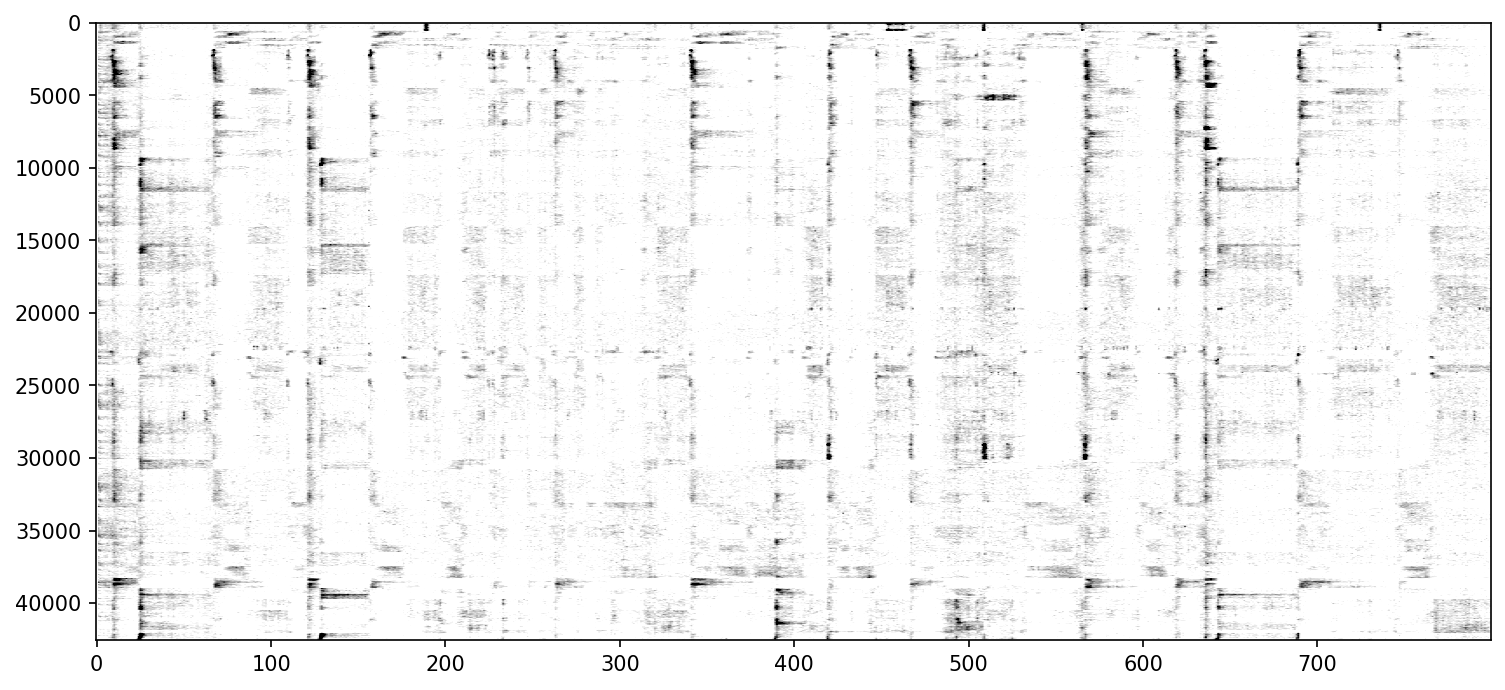

In [189]:
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(zscore(spks_ordered,axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Leinden Algo 

## Louvian - Leiden algo

## Louvian

>The Louvain algorithm searches for high-quality clusters by moving individual nodes—for instance individual articles in a citation network—from one cluster to another in such a way that the quality of the clusters is improved as much as possible. When clusters cannot be improved further by moving individual nodes, the Louvain algorithm does something ingenious: it aggregates the network, so that each cluster in the original network becomes a node in the aggregated network. In the aggregated network, the algorithm then starts to move individual nodes from one cluster to another.

--
## BIG FLAW: 

*Sometimes, a node functions as a middle man or a bridge for the rest of its cluster. Without that crucial node, the cluster would not be connected anymore. Since the Louvain algorithm keeps moving nodes from one cluster to another, at some point it may move the crucial node to a different cluster, thereby breaking the connectivity of the original cluster*

## Leiden

Leiden algorithm is able to split clusters instead of only merging them, as is done by the Louvain algorithm. By splitting clusters in a specific way, the Leiden algorithm guarantees that clusters are well-connected. Moreover, the algorithm guarantees more than this: if we run the algorithm repeatedly, we eventually obtain clusters that are subset optimal.

*This means that it is impossible to improve the quality of the clusters by moving one or more nodes from one cluster to another*

Rather than continuously checking for all nodes in a network whether they can be moved to a different cluster, as is done in the Louvain algorithm, the Leiden algorithm performs this check only for so-called unstable nodes. As a result, the Leiden algorithm does not only find higher quality clusters than the Louvain algorithm, it also does so in much less time.

In [194]:
import scanpy as sc
adata = sc.AnnData(spks)
sc.tl.pca(adata, n_comps=128)
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=128) #matching previous hyperparameters
sc.tl.leiden(adata, resolution=1)
leiden_labels = adata.obs['leiden'].astype(int)

In [198]:
print(f'number of clusters by leiden algo: { len(np.unique(leiden_labels))}')

number of clusters by leiden algo: 13


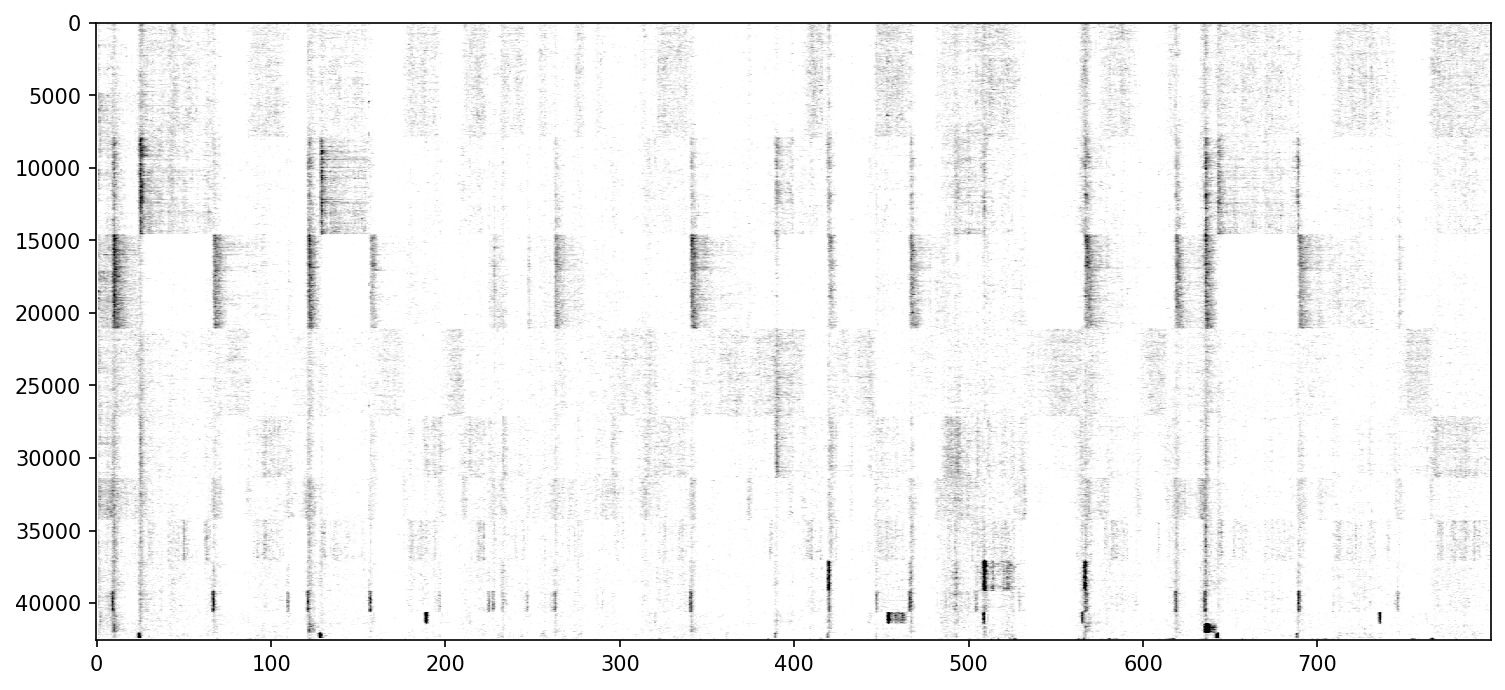

In [195]:
sort_idx=np.argsort(leiden_labels) 
pc_sort_leid=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_leid, vmin=0, vmax=2, cmap='gray_r', aspect='auto')